In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

In [2]:
RAW_DIRECTORY = Path("../data/raw")

In [3]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df["Date"] = pd.to_datetime(df["Date"])
    df["Change"] = df["Close"].pct_change()
    df = df[["Date", "Change"]].set_index("Date")
    return df

In [4]:
series = {}
for filepath in RAW_DIRECTORY.iterdir():
    ticker = filepath.stem
    df = pd.read_csv(filepath)
    df = preprocess(df)
    series[ticker] = df["Change"]
final_df = pd.DataFrame(series)
final_df.tail()

,HRL,SLZ,BCI,THD,ROV,ITL,DOW,PBG,MEG,VEE,...,KIN,TRN,CEZ,LRK,SPL,EPR,IPE,CWP,UFC,PBF
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,-0.091703,0.008403,NaN,-0.021875,0.0,-0.007722,-0.023256,NaN,NaN,-0.019802,...,NaN,0.022857,0.011288,NaN,-0.005398,0.004926,0.035144,NaN,NaN,-0.156863
2022-02-01,0.052885,-0.125000,NaN,-0.022364,0.0,-0.062257,0.111111,NaN,NaN,-0.121212,...,NaN,-0.005587,-0.001313,NaN,0.006284,-0.107843,-0.033951,NaN,NaN,-0.023256
2022-02-02,NaN,-0.019048,NaN,-0.026144,0.0,0.041494,0.007143,0.0,NaN,0.000000,...,NaN,-0.002809,-0.011177,NaN,0.028385,0.120879,0.031949,NaN,NaN,0.035714
2022-02-03,NaN,0.203883,NaN,0.033557,0.0,-0.003984,0.014184,NaN,NaN,-0.051724,...,NaN,0.000000,NaN,NaN,NaN,0.004902,-0.030960,NaN,NaN,-0.022989
2022-02-04,NaN,0.048387,NaN,0.019481,0.0,0.000000,-0.034965,NaN,NaN,0.018182,...,NaN,0.002817,NaN,NaN,NaN,0.004878,0.006390,NaN,NaN,-0.117647


In [5]:
complete_tickers = final_df.columns[~final_df["2020":"2021"].isna().any()]

In [27]:
df = final_df[complete_tickers]["2020":"2021"]
df.head()

,THD,1AT,PCR,GPW,PHN,APT,AGT,FOR,QRS,PKP,...,XTP,UNT,GTC,IMS,LBW,MDA,LWB,ECH,TRN,SPL
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.048980,0.039480,0.038850,0.013998,0.012916,0.009566,-0.015950,0.096774,0.081545,0.034146,...,-0.032258,0.032263,0.002066,-0.002583,0.005051,0.053254,0.047346,-0.004286,0.028241,0.009757
2020-01-03,0.003891,0.025311,0.047241,0.028866,-0.034065,-0.023611,0.032418,0.000000,-0.019841,-0.014151,...,-0.004167,-0.020836,0.000000,-0.033156,0.000000,-0.011236,-0.013699,0.008609,-0.017784,-0.012225
2020-01-07,0.000000,0.012330,0.015037,0.004862,0.074965,0.014477,-0.028739,-0.003922,-0.008097,0.009569,...,0.000000,-0.039000,0.051546,-0.010548,0.042714,0.000000,0.000000,0.049057,0.013178,-0.013065
2020-01-08,-0.015504,0.017093,-0.007397,-0.010892,0.024561,0.000000,-0.024658,-0.007874,0.081633,-0.023697,...,-0.046025,0.007368,-0.005882,0.018669,0.014458,-0.102273,-0.019444,-0.004091,0.024356,-0.021820
2020-01-09,0.047244,0.004780,-0.018661,-0.018418,0.007962,0.000000,0.000000,0.031746,0.018868,0.000000,...,0.017544,-0.007314,0.001972,0.010465,-0.004751,0.012658,-0.001416,-0.028573,-0.004784,0.019621


## Plot of daily returns

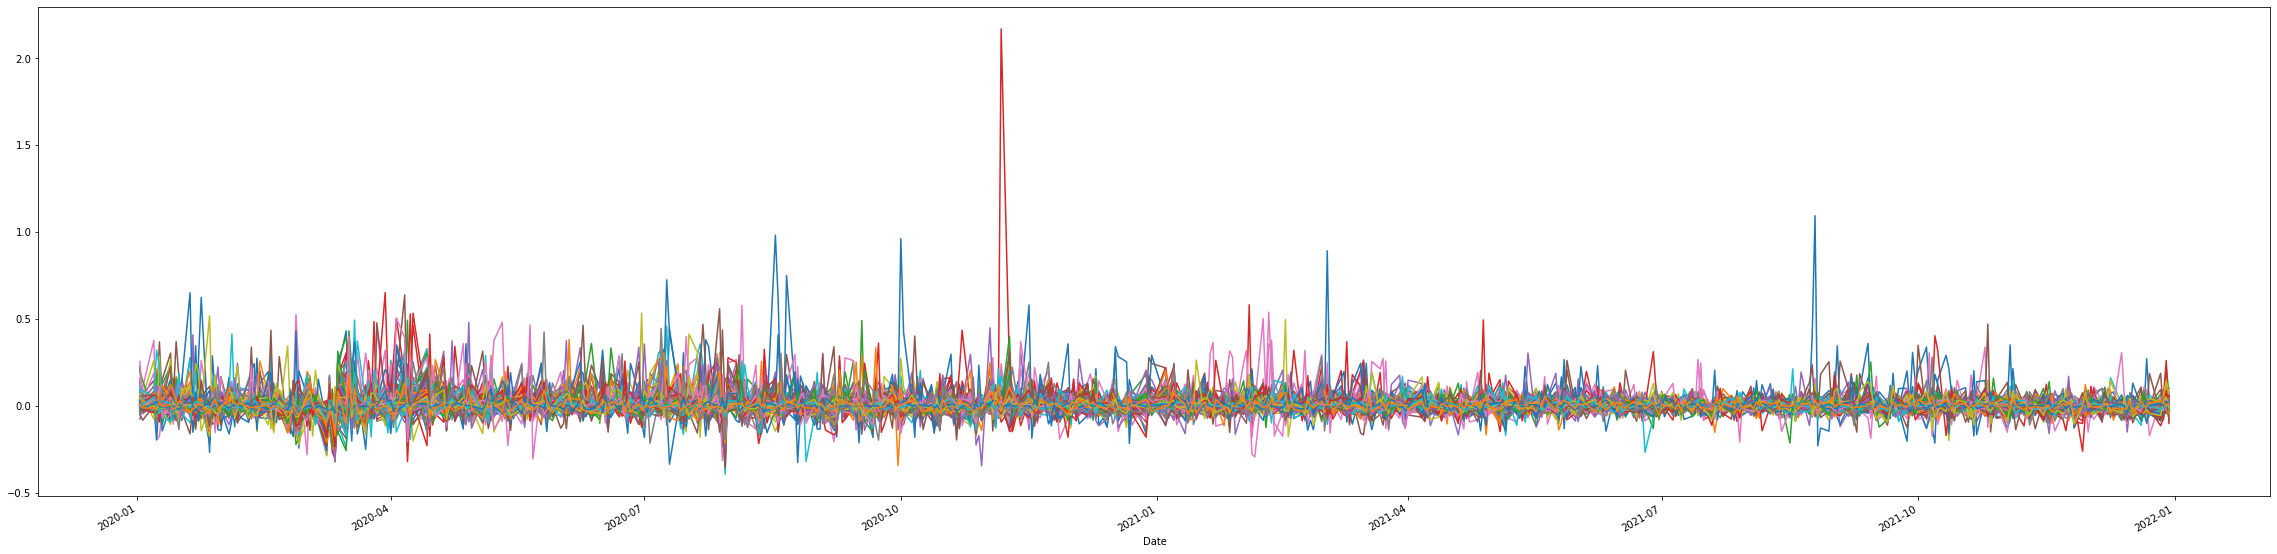

In [28]:
fig, ax = plt.subplots(figsize=(40, 10))
df.plot(ax=ax, legend=False)
plt.show()

## Mean and standard deviation of daily returns

In [29]:
mean_std_df = df.agg(["mean", "var"]).transpose()

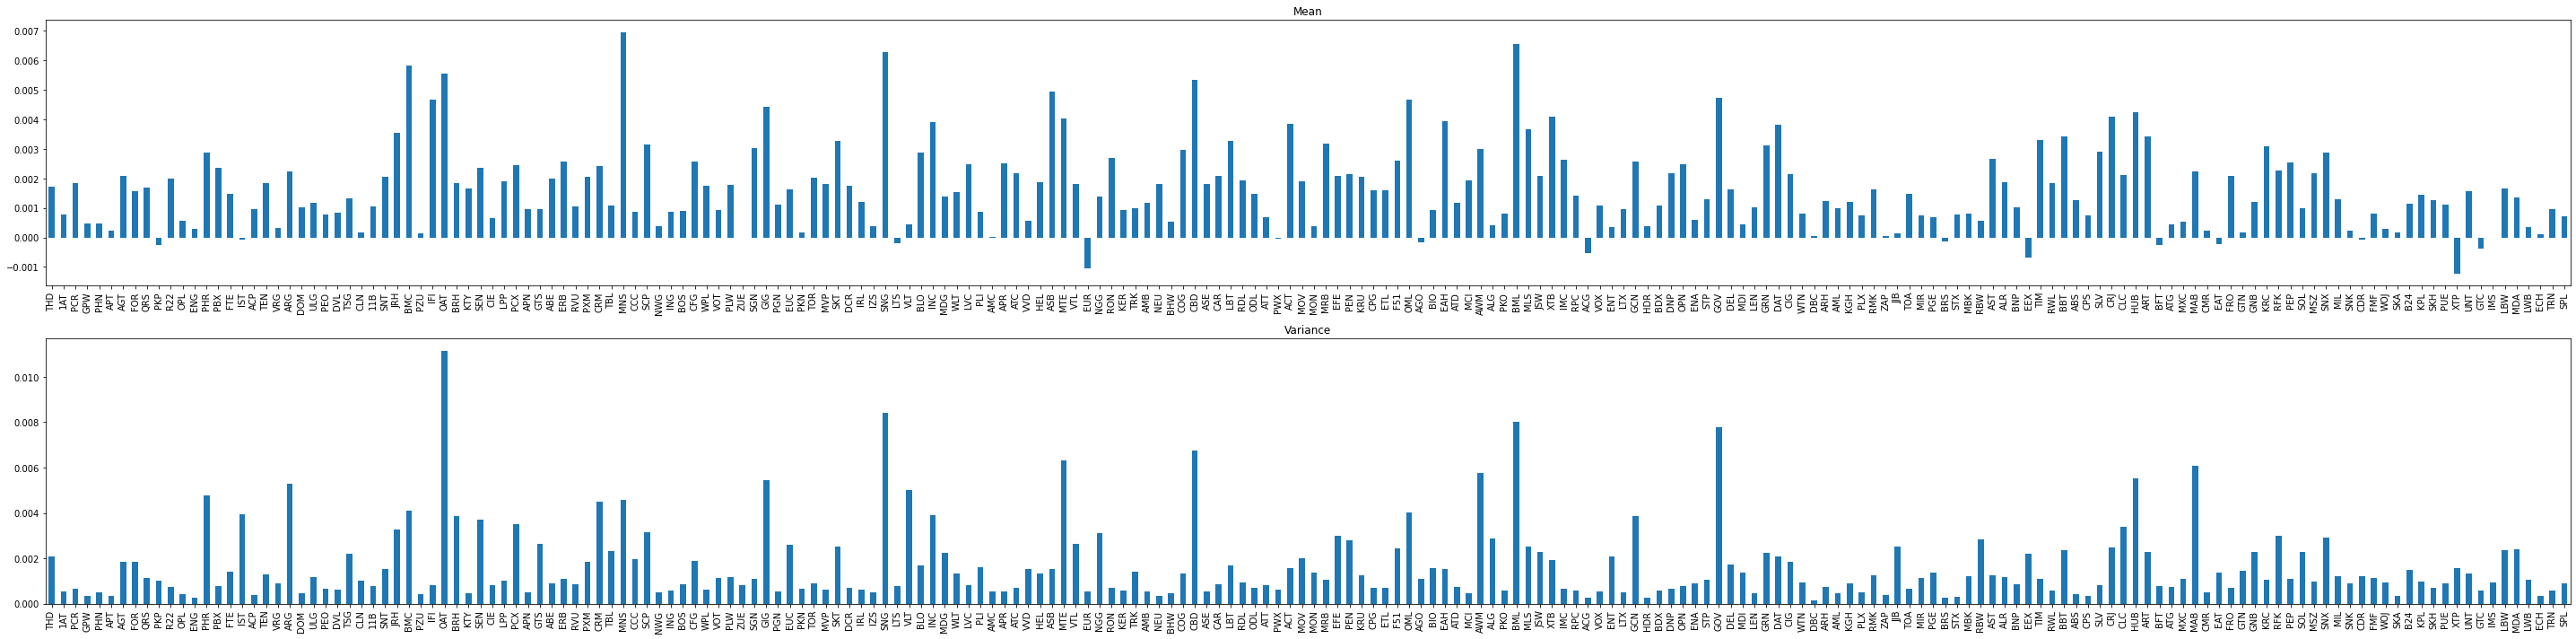

In [30]:
fig, axs = plt.subplots(2, figsize=(40, 10))
mean_std_df["mean"].plot(kind="bar", ax=axs[0], title="Mean")
mean_std_df["var"].plot(kind="bar", ax=axs[1], title="Variance")
fig.tight_layout()
plt.show()

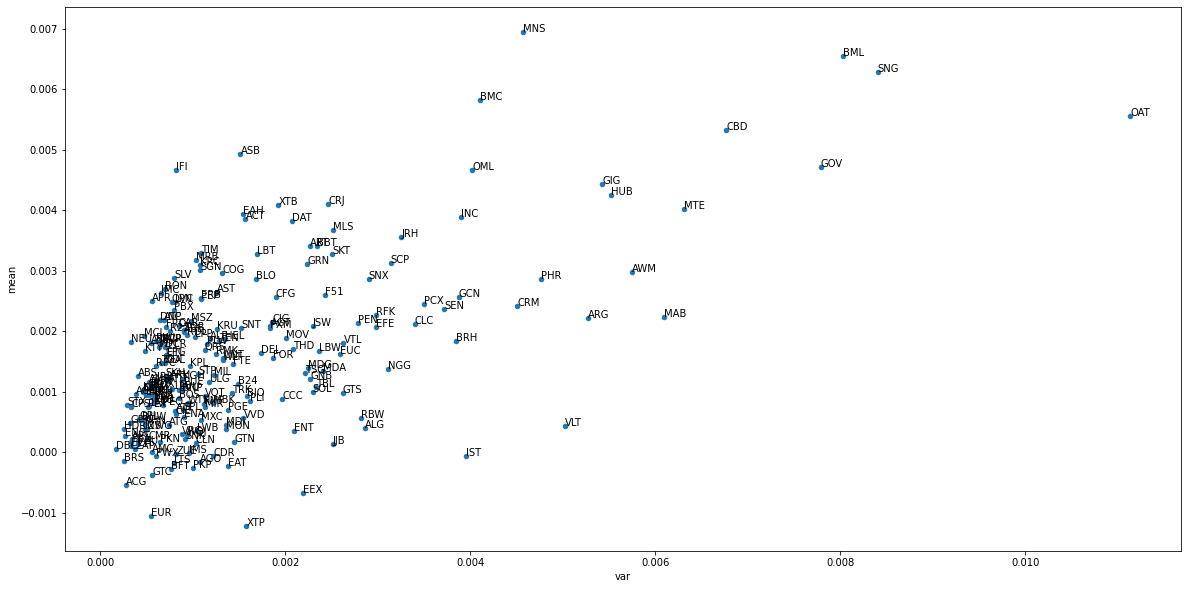

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

plt.show()

## Modern portfolio theory

In [32]:
from qpsolvers import solve_qp

In [33]:
SIGMA = df.cov().to_numpy()
R = df.mean().to_numpy()

In [34]:
def get_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1))

def get_nonnegative_weights(q):
    return solve_qp(2 * SIGMA, -q * R, None, None, np.ones_like(R), np.ones(1), np.zeros_like(R))

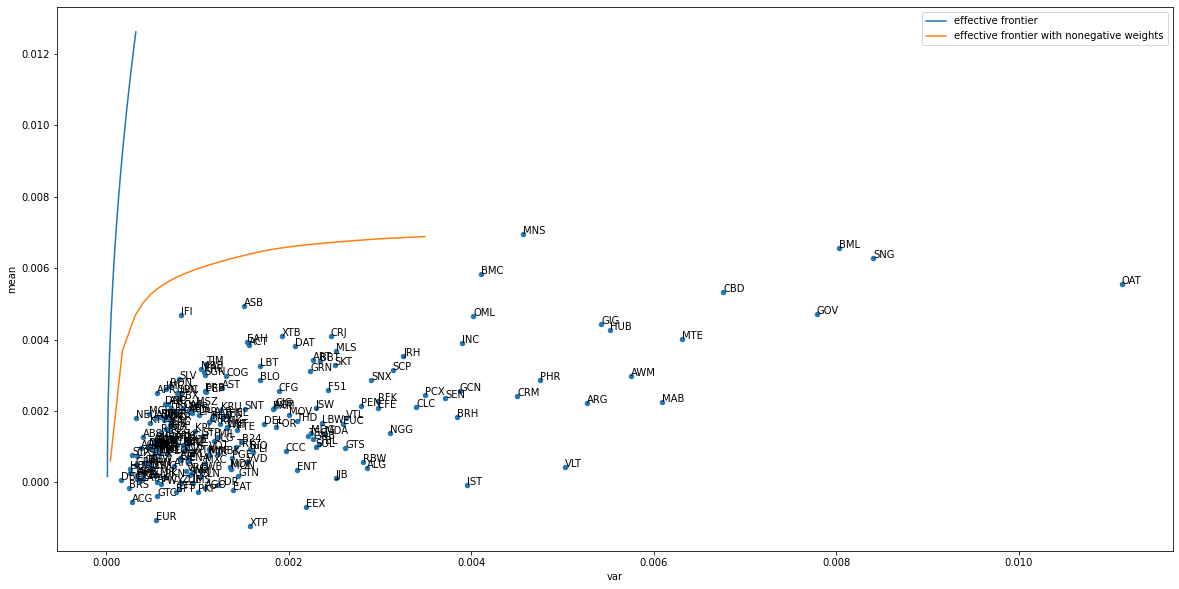

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
mean_std_df.plot("var", "mean", kind="scatter", ax=ax)

for _, row in mean_std_df.iterrows():
    ax.annotate(row.name, (row["var"], row["mean"]))

arr = []
for q in np.linspace(0, 0.05, 100):
    w = get_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    arr.append([vol, ret])

nonneg_arr = []
for q in np.linspace(0, 10, 100):
    w = get_nonnegative_weights(q)
    vol, ret = w.T @ SIGMA @ w, np.dot(R, w)
    nonneg_arr.append([vol, ret])

arr = np.array(arr)
nonneg_arr = np.array(nonneg_arr)
ax.plot(arr[:, 0], arr[:, 1], label="effective frontier")
ax.plot(nonneg_arr[:, 0], nonneg_arr[:, 1], label="effective frontier with nonegative weights")
ax.legend()
plt.show()

# Experiments with NSGA2

In [46]:
from nsga2.objectives import get_objective, portfolios_neg_returns, portfolios_vars, portfolios_empirical_VaR, portfolios_semivariances
from nsga2.model import NSGA2
from nsga2.mutations import PolynomialMutation
from nsga2.crossovers import SBX, PMX

from tqdm import tqdm

In [44]:
temp_df = df.agg(["mean"]).T
temp_df["variance"] = portfolios_vars(np.eye(len(df.columns)), SIGMA)
temp_df["semivariance"] = portfolios_semivariances(np.eye(len(df.columns)), np.asarray(df))
temp_df["VaR95"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.95)
temp_df["VaR99"] = portfolios_empirical_VaR(np.eye(len(df.columns)), np.asarray(df), 0.99)
temp_df.head()

,mean,variance,semivariance,VaR95,VaR99
THD,0.001714,0.002085,0.001611,0.062355,0.131020
1AT,0.000762,0.000522,0.000477,0.032643,0.063983
PCR,0.001828,0.000668,0.000589,0.036799,0.061521
GPW,0.000481,0.000324,0.000307,0.026706,0.048621
PHN,0.000472,0.000483,0.000332,0.029680,0.052024


In [45]:
weights_arr = []
for q in tqdm(np.linspace(0, 0.05, 10000)):
    weights_arr.append(get_weights(q))
weights_arr = np.asarray(weights_arr)

In [48]:
def objective(weights: np.ndarray) -> np.ndarray:
    return np.stack(
        [
            np.maximum(-0.01, portfolios_neg_returns(weights, R=R)),
            portfolios_vars(weights, SIGMA=SIGMA),
            portfolios_semivariances(weights, returns=np.asarray(df)),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.95),
            portfolios_empirical_VaR(weights, returns=np.asarray(df), alpha=0.99),
        ], axis=-1,
    )

In [56]:
def plot(history, start=2, end=None):
    fig, axs = plt.subplots(2, 2, figsize=(40, 20))
    axs = axs.flatten()
    temp_df.plot("variance", "mean", kind="scatter", ax=axs[0], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("semivariance", "mean", kind="scatter", ax=axs[1], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR95", "mean", kind="scatter", ax=axs[2], label="stocks", c="orange", s=50, marker="o")
    temp_df.plot("VaR99", "mean", kind="scatter", ax=axs[3], label="stocks", c="orange", s=50, marker="o")

    end = np.log2(len(history)).astype(int) if end is None else end
    bounds = np.exp2(np.arange(start, end + 2)).astype(int)
    cmap = mpl.cm.get_cmap("viridis")
    norm = mpl.colors.BoundaryNorm(bounds / 1.5, cmap.N)
    idxs = bounds[:-1] - 1

    for obj, ax in zip(range(1, history.shape[-1]), axs):
        c = ax.scatter(history[idxs, :, obj], -history[idxs, :, 0], c=np.broadcast_to(idxs[..., None], (idxs.shape[0], history.shape[1])), cmap=cmap, norm=norm, alpha=0.6)
        fig.colorbar(c, ax=ax, label="iteracja", ticks=idxs+1)

    axs[0].scatter(portfolios_vars(weights_arr, SIGMA), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[1].scatter(portfolios_semivariances(weights_arr, np.asarray(df)), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[2].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.95), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)
    axs[3].scatter(portfolios_empirical_VaR(weights_arr, np.asarray(df), 0.99), -portfolios_neg_returns(weights_arr, R), label="effective frontier for mean-variance weights", c="r", s=5)

    for ax in axs:
        ax.legend()
        ax.set_xscale("log")
    plt.show()

In [58]:
model = NSGA2(len(R), population_size=500, n_iterations=int(2**15), mutation=PolynomialMutation(-1, 1))
history = model.simulate(objective)

100%|██████████| 32768/32768 [1:50:20<00:00,  4.95it/s]  


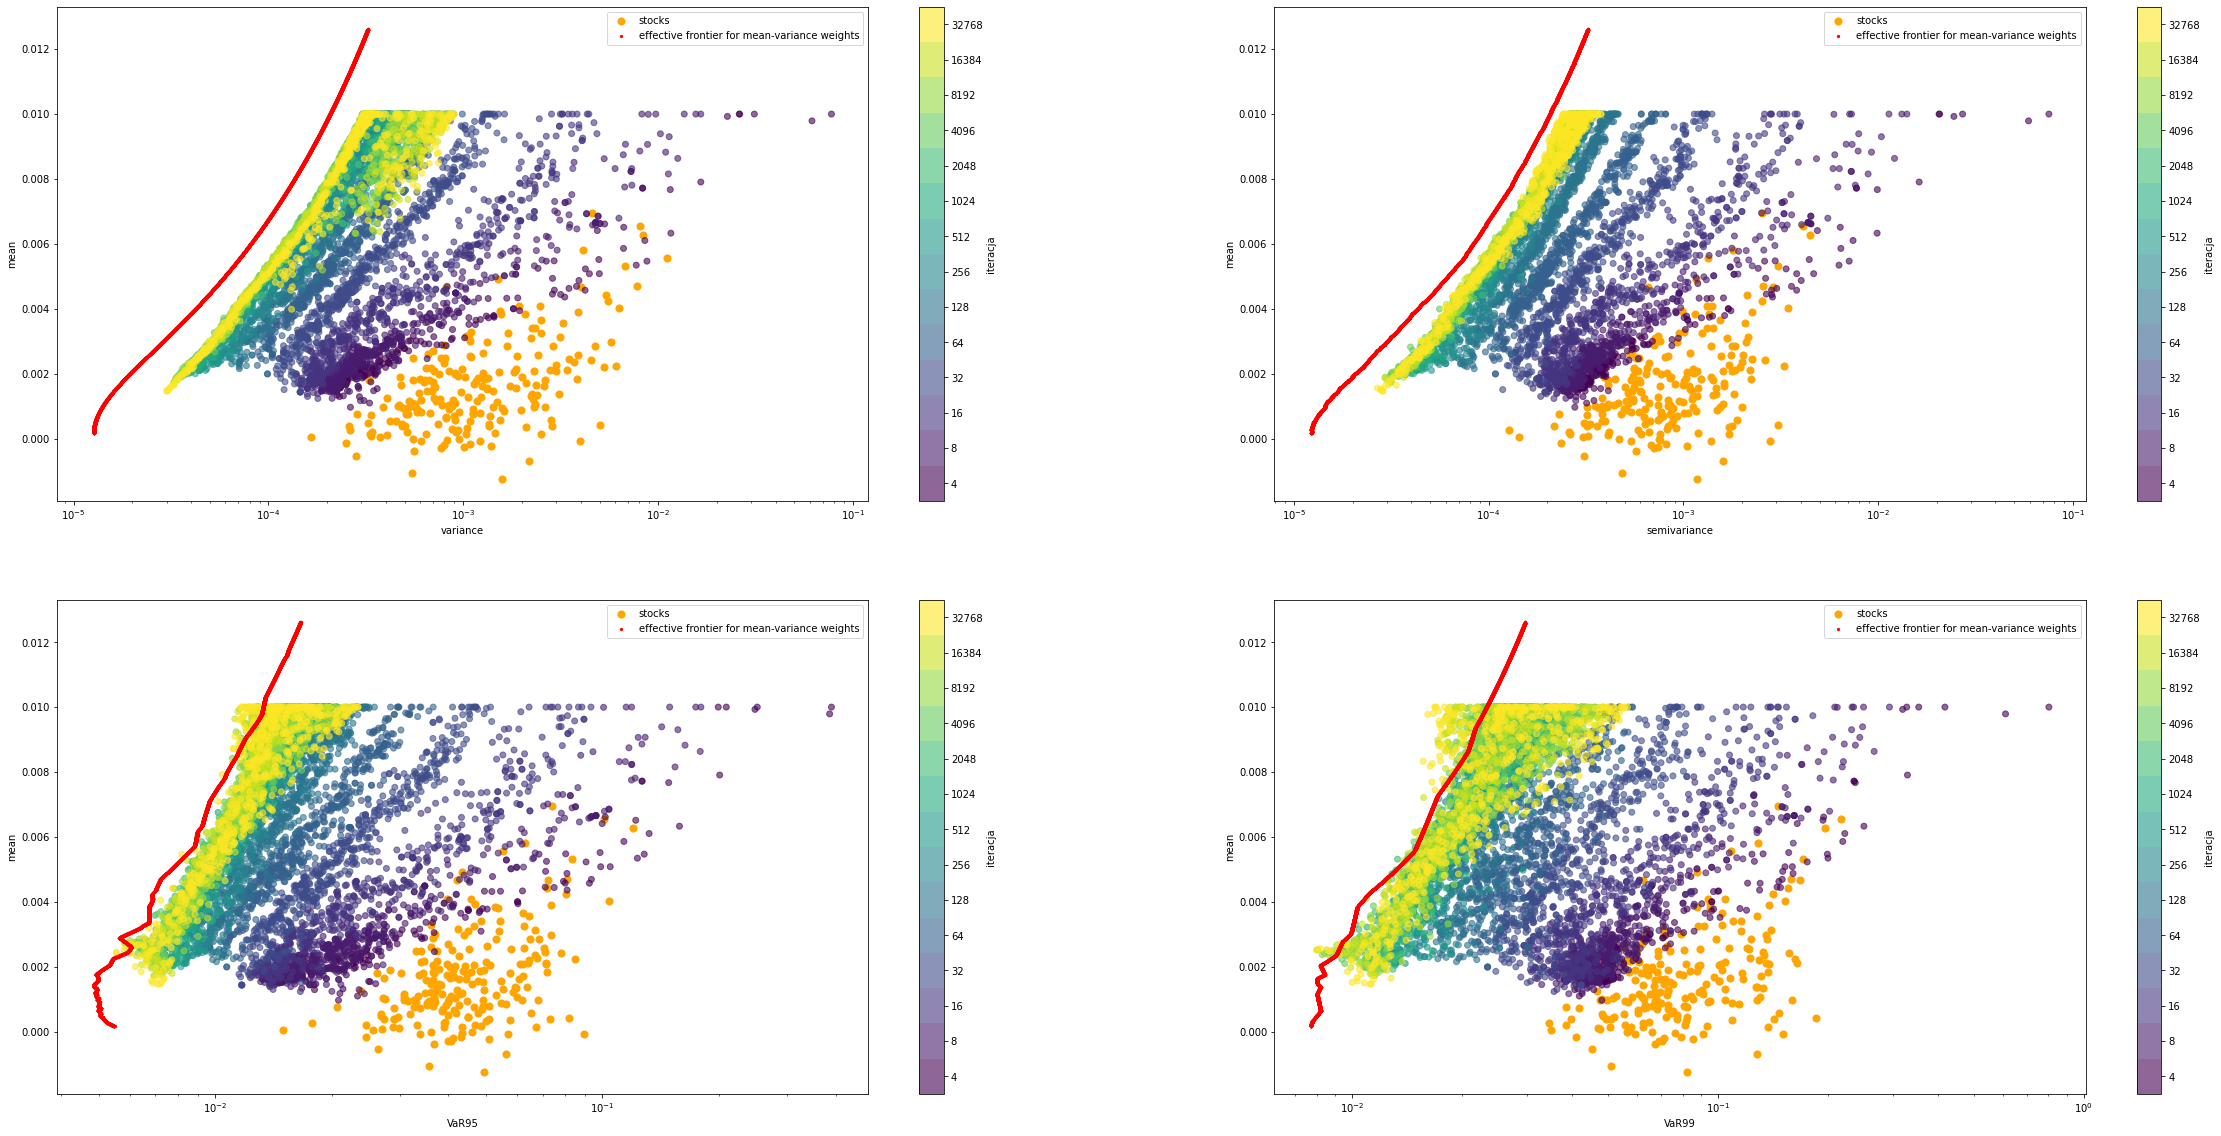

In [59]:
plot(history)